## Bibliotecas

In [1]:
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Funciones de lectura y mostrado de imágenes

### Función para imprimir imagenes de opencv con matplot  

Deja preparada la imagen _im_, ya sea a color o en escala de grises, para que al hacer _plt.show()_ la muestre por pantalla con el título _title_. Normaliza --> convierte a una escala de color reconocible --> muestra

In [2]:
def plt_imshow(im, title = ''):
    
    # NORMALIZAMOS  
    # Si es a color
    if len(im.shape) == 3:
        im[:,:,0] = (im[:,:,0] - np.min(im[:,:,0])) / (np.max(im[:,:,0]) - np.min(im[:,:,0]))*255
        im[:,:,1] = (im[:,:,1] - np.min(im[:,:,1])) / (np.max(im[:,:,1]) - np.min(im[:,:,1]))*255
        im[:,:,2] = (im[:,:,2] - np.min(im[:,:,2])) / (np.max(im[:,:,2]) - np.min(im[:,:,2]))*255
        
    # SI es en ByN normalizamos la imagen entera (solo tiene un canal)
    else:
        im[:,:] = (im[:,:] - np.min(im[:,:])) / (np.max(im[:,:]) - np.min(im[:,:]))*255
        
    # Si la imagen es a color
    if len(im.shape) == 3:
        im_plt = cv2.cvtColor(im,cv2.COLOR_BGR2RGB) # La cambiamos a RGB
        plt.imshow(im_plt) # mostramos
        
    else: # Si es gris
        plt.imshow(im, cmap='gray') # Mostramos en escala de grises
    plt.title(title) # añadimos un título

### Función para la lectura de imágenes  

Recive como parámetro el _path_ hasta la imagen y el modo de color de opencv a emplear. Delvuelve la imagen en _float64_ para trabajar con ella.

In [3]:
def leer_imagen(path, color = None):

    # Si queremos leer la imagen en BGR
    if color == None:
        im_cv = cv2.imread(path)
        
    # Si queremos leer la imagen en ByN
    elif color == 0:
        im_cv = cv2.imread(path, 0)

    # Devolvemos la imagen para cv y para plt
    return np.float64(im_cv)

# Funciones que implementan el funcionamiento de los distintos ejercicios

## Gaussiana 1D

Obtenemos el kernel de una función Gaussiana de tamaño _kernel\_size_ , $\sigma$ = _sigma_ y bordes de tipo _borde_ y lo aplicamos por filas y columnas a la imagen pasada como parámetro.

In [4]:
def Gaussiana1D(im, kernel_size, sigma, borde):

    # Obtenemos una máscara 1D de tamaño <kernel_size> de una función Gaussiana de sigma = <sigma>
    gk = cv2.getGaussianKernel(kernel_size,sigma) # 1D -> filas
    # Calculamos la transpuesta a esta máscara 1D
    gkt = gk.T # 1D -> columnas

    im2 = cv2.filter2D(im, -1, gk, borderType=borde) # aplicamos la máscara por filas
    im2 = cv2.filter2D(im2, -1, gkt, borderType=borde) # aplicamos la máscara por columnas
    
    return im2

## Gaussiana 2D 

Obtenemos el kernel de una función Gaussiana de tamaño _kernel\_size_, $\sigma$ = _sigma_ y bordes de tipo _borde_. Tras esto multiplicamos el kernel obtenido por su traspuesta para obneter una máscara 2D para aplicarla a la imagen.

In [5]:
def Gaussiana2D(im, kernel_size, sigma, borde):

    # Obtenemos una máscara 1D de tamaño <kernel_size> de una función Gaussiana de sigma = <sigma>
    gk = cv2.getGaussianKernel(kernel_size,sigma)
    # Obtenemos la máscara 2D mediante la multiplicación matricial de la máscara
    # 1D por su transpuesta
    gk_2d = np.dot(gk, gk.T)
    # Aplicamos la máscara 2D
    im2 = cv2.filter2D(im, -1, gk_2d, borderType=borde)

    return im2

## Sobel (getDerivKernels)

Aplicamos Sobel de tamaño _kernel\_size_ en _x_ e _y_ a la imagen _im_ con configuración de bordes = _borde_ .  
Sobel suaviza la imagen y después calcula su derivada en un determinado eje con la intención de detectar los bordes de la imagen o, más concretamente, los cambios de frecuencia (intensidad de color).  
Obtenemos los kernels de ambos ejes y los multiplicamos matricialmente para obtener una máscara 2D la cual tendremos que voltear en ambos ejes para que al aplicarla realicemos una convolución. Tras esto aplicamos estas máscaras por separado obteniendo dos imágenes una con un resalto de bordes en el eje horizontal y otra en el vertical.

In [6]:
def gradiente(im, kernel_size, borde):

    kx = cv2.getDerivKernels(1, 0, kernel_size, normalize=True) # kernel para derivar + kernel para suavizar en x
    ky = cv2.getDerivKernels(0, 1, kernel_size, normalize=True) # kernel para suavizar + kernel para derivar en y

    kx = np.dot(kx[1], kx[0].T) # Obtenemos una máscara 2D para aplicar la máscara de Sobel en x (suavizado x derivada)
    ky = np.dot(ky[1], ky[0].T) # Obtenemos una máscara 2D para aplicar la máscara de Sobel en y (derivada x suavizado)

    # Hacemos un flip en ambos ejes en las dos máscaras
    # para realizar una convolución en vez de una correlación
    kx = cv2.flip(kx, -1)
    ky = cv2.flip(ky, -1)

    # Aplicamos la máscara Sobel en X y en Y
    im2 = cv2.filter2D(im, -1, kx, borderType=borde)
    im3 = cv2.filter2D(im, -1, ky, borderType=borde)
    
    # Devolvemos las imágenes con la máscara aplicada
    return im2, im3

## Laplaciana de Gaussiana

La Laplaciana de Gaussiana es lo mismo que la segunda derivada de la Gaussiana.  
Recive como parámetro una imagen _im_ a la que aplicar el filtro, un tamaño de máscara _kernel\_size_, un valor de $\sigma$ = _sigma_ para calcular la Gaussiana y un tipo de _borde_ a aplicar.

Primero obtenemos la gaussiana de la imagen y después la derivamos en ambos ejes obteniendo una derivada en el eje x y otra derivada en el eje y. La imagen que queremos es la suma de estas dos.

In [7]:
def LoG(im, kernel_size, sigma, borde):
    im_gauss = Gaussiana2D(im,kernel_size,sigma,borde) # Aplicamos el filtro de Gaussiana

    kx = cv2.getDerivKernels(1, 0, kernel_size, normalize=True) # kernel para derivar + kernel para suavizar en x
    ky = cv2.getDerivKernels(0, 1, kernel_size, normalize=True) # kernel para suavizar + kernel para derivar en y

    # Creamos dos kernels (arrays) de igual tamaño al de las derivadas
    # Esto lo hacemos porque getDerivKernels nos da un kernel a parte de la derivada que sirve para suavizar la imagen
    # Como ya hemos suavizado la imagen con la Gaussiana solo queremos aplicar la derivada
    # Por eso creamos un kernel de solo 1s que no altera la imagen
    kx_1 = np.ones_like(kx[0])
    ky_1 = np.ones_like(ky[1])

    kx = np.dot(kx_1, kx[0].T) # Obtenemos una máscara 2D para derivar en x
    ky = np.dot(ky[1], ky_1.T) # Obtenemos una máscara 2D para derivar en y

    # Preparamos para la convolución
    kx = cv2.flip(kx, -1)
    ky = cv2.flip(ky, -1)

    # Aplicamos cada filtro de derivada dos veces (derivamos dos veces)
    im2 = cv2.filter2D(im_gauss, -1, kx, borderType=borde)
    im2 = cv2.filter2D(im2, -1, kx, borderType=borde)
    im3 = cv2.filter2D(im_gauss, -1, ky, borderType=borde)
    im3 = cv2.filter2D(im3, -1, ky, borderType=borde)

    # Sumamos las imágenes
    img = (im2 + im3)
    
    return img

## Subsample

Reducimos la imagen pasada como parámetro suprimiendo las filas y columnas pares.

In [8]:
def imageSubsample(im):
    # Creamos una "imagen" (matriz) con unas dimensiones igual a la mitad (en ambos ejes) de la original
    im2 = np.ones((int(im.shape[0]/2), int(im.shape[1]/2)))
    
    # Copiamos la imagen original en la creada anteriormente
    # saltándonos las filas y columnas de 2 en 2
    for i in range(int(im.shape[0]/2)):
        for j in range(int(im.shape[1]/2)):
            im2[i,j] = im[i*2,j*2]
            
    return im2

## Upsample

Aumentamos el tamaño de la imagen pasada como argumento insertando cada fila y columna dos veces

In [9]:
def imageUpsample(im):
    # Creamos una "imagen" (matriz) con unas dimensiones igual al doble (en ambos ejes) de la original
    im2 = np.ones((int(im.shape[0]*2), int(im.shape[1]*2)))
    
    # Copiamos la imagen original en la creada anteriormente
    # doplicando las filas y columnas de 2 en 2
    for i in range(int(im2.shape[0])):
        for j in range(int(im2.shape[1])):
            im2[i,j] = im[int(i/2),int(j/2)]
            
    return im2

## Pyramid

Recive como parámetro un vector de 5 imágenes de manera que v[i+1] es el subsample de v[i].  
Crea una imagen en forma de "pirámide" compuesta por las imágenes del vector _v\_img_ con la intención de representarlas de una forma más vistosa y útil que permite compararlas.

En primer lugar crea una serie de imágenes en blanco que actuarán como fondo de las pasadas como parámetro y las complementan para formar una nueva imagen de un tamaño específico que encaje en la composición de la pirámide. Todo el algoritmo está dedicado a ajustar las imágenes con su fondo correspondiente y a concatenarlas entre sí para que al final tenga forma de "pirámide".

In [10]:
def pyramid(v_img):
    # Creamos imágenes que serán el fondo de las imágenes de la pirámide
    blanco2 = np.ones_like(v_img[2])*255 # Fondo para nivel 2 (mismo tamaño)
    blanco3 = np.ones_like(v_img[3])*255
    blanco3 = np.concatenate((blanco3, blanco3, blanco3), axis=1) # Fondo nivel3. repetimos tres veces en horizontal
    blanco4 = np.ones_like(v_img[4])*255 # Fondo para nivel 4
    blanco4_2 = np.ones((v_img[4].shape[0]*2, v_img[1].shape[1]-v_img[4].shape[1]))*255 # Fondo para nivel 4
    
    # Fijamos los distintos niveles de la pirámide
    level0 = v_img[0]
    level1 = v_img[1]
    # Concatenamos con los fondos para que tengan el tamaño adecuado
    level2 = np.concatenate((v_img[2], blanco2), axis=1)
    level3 = np.concatenate((v_img[3], blanco3), axis=1)
    level4 = np.concatenate((v_img[4], blanco4), axis=0)
    level4 = np.concatenate((level4, blanco4_2), axis=1)
    
    # Rellenamos filas y/o columnas
    # que no han quedado igualadas con los fondos
    if level1.shape[1] != level2.shape[1]:
        dif = level1.shape[1] - level2.shape[1]
        relleno = np.ones((level2.shape[0], dif))*255
        level2 = np.concatenate((level2, relleno), axis = 1)
    if level1.shape[1] != level3.shape[1]:
        dif = level1.shape[1] - level3.shape[1]
        relleno = np.ones((level3.shape[0], dif))*255
        level3 = np.concatenate((level3, relleno), axis = 1)
    if level1.shape[1] != level4.shape[1]:
        dif = level1.shape[1] - level4.shape[1]
        relleno = np.ones((level4.shape[0], dif))*255
        level4 = np.concatenate((level4, relleno), axis = 1)    
    
    # Concatenamos toda la parte derecha de la pirámide
    derecha = np.concatenate((level1, level2, level3, level4), axis=0)
    
    # Ajustamos la longitud de los ejes de la parte derecha
    if level0.shape[0] != derecha.shape[0]:
        dif = level0.shape[0] - derecha.shape[0]
        relleno = np.ones((dif, derecha.shape[1]))*255
        derecha = np.concatenate((derecha, relleno), axis = 0)
    
    # Unimos la parte derecha con el nivel 0
    final = np.concatenate((level0, derecha), axis=1)
    
    # Devolvemos la pirámide
    return final

## Hibridación

Recive como parámetro las dos imágenes a hibridar (_im1_, _im2_), así como el tamaño de máscara y el valor de sigma (_kernel1, kernel2, sigma1, sigma2_) que se utilizará para calcular la gaussiana de cada una de ellas.

A la primera imagen solo le calcularemos su Gaussiana, mientras que a la segunda le calcularemos su Gaussiana únicamente como paso intermedio para obtener las frecuencias altas. Una vez tenemos las frecuencias bajas de la primera imagen (su Gaussiana) y las frecuencias altas de la segunda (original - su Gaussiana) sumamos las dos imágenes resultantes para obtener la imagen híbrida. Además, se devuelve junto con la imagen híbrida, una imagen que muestra las dos imágenes procesadas por separado junto con la híbrida.

In [11]:
def hybrid(im1, im2, kernel1, kernel2, sigma1, sigma2):
    # Gaussiana de la imagen de bajas frecuencias
    baja1 = Gaussiana1D(im1, kernel1, sigma1, cv2.BORDER_CONSTANT)
    # Gaussiana de la imagen de altas frecuencias
    baja2 = Gaussiana1D(im2, kernel2, sigma2, cv2.BORDER_CONSTANT)
    # Obtenemos las altas frecuencias restando a la original la Gaussiana
    alta2 = np.copy(im2 - baja2)
    # Sumamos para hibridar
    hyb = baja1+alta2
    
    # Obtenemos una imgen que muestre las tres imágenes a la vez
    # Baja frecuencia, alta frecuencia e híbrida
    fin = np.concatenate((baja1, alta2, hyb), axis=1)
    
    return fin, hyb

## Imprime híbrida

Recive como parámetro los mismos argumentos que la función _hybrid_ ya que serán estos mismos los que serán pasados.  
Esta función solo se encarga de leer las dos imágenes que se le pasarán como argumento a la función _hybrid_, llamar a dicha función y mostrar el resultado.

In [12]:
def imprimeHybrid(im1, im2, k1, k2, s1, s2):
    # Leemos la imagen que será de bajas frecuencias
    low = leer_imagen(im1, 0)
    # Leemos la imagen que será de altas frecuencias
    high = leer_imagen(im2, 0)
    # Llamamos a la función para hibridar
    mix, hyb = hybrid(low, high, k1, k2, s1, s2)
    
    # Establecemos el tamaño de la imagen y mostramos
    plt.figure(num=None, figsize=(15,15))
    input('Mostrar imagen híbrida')
    plt_imshow(mix)
    plt.show()
    
    return hyb

## Blob detection

Recibe como parámetros el número de escalas a realizar (cuántas veces modificaremos sigma), la imagen en la que queremos encontrar los _blobs_, un valor inicial de sigma, un tamaño para el kernel y un umbral a partir del cual consideraremos importante el blob detectado.  

Creamos una imagen _fin_ de 0s del mimo tamaño que la original

Para cada una de las escalas:  
- Calcularemos la Laplaciana de Gaussiana de la imagen, la normalizaremos multiplicándola por $\sigma^2$ y elevaremos el resultado al cuadrado.  
- Creamos una matriz (imagen) a la que llamaremos _Z_ del mismo tamaño que la original con todos sus valores a 0 (negro) en la que iremos guardando los blobs detectados.  
- Recorremos la Laplaciana de Gaussiana pixel a pixel comprobando que sea el máximo de su vecindario $3x3$ (es un blob). Si lo es , guardamos ese pixel en la matriz de 0s.
- Una vez hayamos detectado los blobs de la imagen en esa escala de $\sigma$, normalizamos Z y dibujamos un círculo en todos aquellos blobs que superen el valor de umbral pasado.
- Sumamos _fin_ + _Z_
- Aumentamos el valor de sigma $\sigma = 1.4 * \sigma$

Devolvemos la imagen _fin_ que contiene todos los círculos de las diferentes escalas que marcan zonas de interés en la imagen.

In [13]:
def blob(escalas, im, sigma, kernel, umbral):
    # Copiamos el valor de sigma
    sg = sigma
    # Creamos lo que será la imagen a devolver. Una imagen de 0s de tamaño igual a im
    fin = np.float64(np.zeros_like(im))
    
    # Repetimos tantas veces como escalas tengamos
    for k in range(escalas):
        # Calculamos la Laplaciana de Gaussiana de la imagen
        lg = (LoG(im, kernel, sg, cv2.BORDER_REFLECT_101)*sigma**2)**2
        # Creamos una imagen igual que 'fin' en la guardaremos los puntos de interés encontrados
        z = np.float64(np.zeros_like(im))
        
        # Recorremos los píxeles de la imagen
        for i in range(lg.shape[0]):
            for j in range(lg.shape[1]):
                blob = True
                main = lg[i,j]
                
                # Comprobamos que el píxel en cuestión es máximo en su vecindario 3x3
                if (i-1) >= 0:
                    if lg[i-1,j] >= main:
                        blob = False
                    if (j-1) >= 0:
                        if lg[i-1,j-1] >= main:
                            blob = False
                    if (j+1) < lg.shape[1]:
                        if lg[i-1,j+1] >= main:
                            blob = False
                            
                if (i+1) < lg.shape[0]:
                    if lg[i+1,j] >= main:
                        blob = False
                    if (j-1) >= 0:
                        if lg[i+1,j-1] >= main:
                            blob = False
                    if (j+1) < lg.shape[1]:
                        if lg[i+1,j+1] >= main:
                            blob = False
                            
                if (j-1) >= 0:
                    if lg[i,j-1] >= main:
                        blob = False
                            
                if (j+1) < lg.shape[1]:
                    if lg[i,j+1] >= main:
                        blob = False
                
                # Si es máximo lo guardamos en z
                if blob:
                    z[i,j] = main
        
        # Normalizamos z
        z[:,:] = (z[:,:] - np.min(z[:,:])) / (np.max(z[:,:]) - np.min(z[:,:]))*255
        # Dibujamos los círculos en z en aquellos puntos que superen el umbral
        drawCircles(z, umbral, sg)
        # Establecemos el tamaño de la imagen
        plt.figure(num=None, figsize=(15,15))
        
        # Mostramos los círculos que marcan zonas de interés junto con la imagen original
        input('mostrar resultado escala ' + str(k))
        plt_imshow(np.concatenate((im,z,im+z), axis=1))
        plt.show()
        
        # Añadimos z a fin
        fin += z
        # Aumentamos el valor de sigma
        sg = 1.4*sg
        
    return fin
        

## Dibuja círculos

Toma como parámetros una imagen _z_ en la que se pintarán los círculos, un umbral _u_ que marcará en qué puntos se dibujan los círculos, y un sigma _s_ que marcará el tamaño de esos círculos.

Primero nos hacemos con las columnas y filas en las que los valores de la imagen superan el umbral, agrupamos los valores por parejas para pasárselo a la función _circle_ a la que le pasaremos también la imagen _z_, el tamaño del radio que irá definido por el valor de sigma (lo multiplicamos por 15 para que tome un tamaño visible) y el color del que colorearemos el círculo, en este caso blanco (255).

In [14]:
def drawCircles(z, u, s):
    columnas, filas = np.where(z > u)
    for i in zip(filas, columnas):
        cv2.circle(z, i, int(15*s), color=255)

# Ejercicio 1.

## 1a. Máscara Gaussiana aplicada con máscaras 1D y 2D comparadas con la función GaussianBlur. Máscara de Sobel (derivadas - resaltado de bordes) en _x_ e _y_

- **Qué vamos a calcular**  
Vamos a aplicar un filtro de Gaussiana a una imagen de tres maneras distintas: mediante máscaras de una dimensión, máscaras de dos dimensiones y con la función propia de OpenCV _GaussianBlur()_. También aplicaremos el filtro de Sobel en ambos ejes de la imagen.

- **Cómo lo hacemos**  
Los filtros de Sobel los aplicamos con la función _gradiente()_. Para aplicar la Gaussiana utilizaremos las funciones _Gaussiana1D()_, _Gaussiana2D()_ y _cv2.GaussianBlur()_.

- **Funcionamiento de _gradiente()_**  
Esta función suaviza la imagen y después calcula su derivada en ambos ejes con la intención de detectar los bordes de la imagen o, más concretamente, los cambios de frecuencia (intensidad de color). En ella obtenemos dos parejas de kernels (una pareja para cada eje) y multiplicamos los miembros de las parejas matricialmente para obtener dos máscaras 2D la cuales tendremos que voltear en ambos ejes para que al aplicarlas realicemos una convolución. Tras esto aplicamos estas máscaras por separado obteniendo dos imágenes una con un resalto de bordes en el eje horizontal y otra en el vertical.

- **Funcionamiento _Gaussiana1D()_**  
Obtenemos el kernel de una función Gaussiana de tamaño _kernel\_size_ , $\sigma$ = _sigma_ y bordes de tipo _borde_ y lo aplicamos una vez por filas y otra vez por columnas a la imagen pasada como parámetro.

- **Funcionamiento _Gaussiana2D()_**  
Obtenemos el kernel de una función Gaussiana de tamaño _kernel\_size_, $\sigma$ = _sigma_ y bordes de tipo _borde_. Tras esto multiplicamos el kernel obtenido por su traspuesta para obneter una máscara 2D para así aplicarla una única vez a la imagen.

- **Parámetros**  
>**kernels = [3,15,31]**:  El tamaño máximo de máscara en las funciones Gaussianas es 31 por lo que se intenta escoger valores que representen todo el dominio viable pero sin que sean demasiados como para que haya muchas ejecuciones.  
 **k_size = [1,5,7]**:  Tenemos algo parecido al caso anterior salvo que el valor máximo en la función _gradiente()_ es 7.  
 **sigmas = [1, 3, 9]**:  Con estos tres valores de sigma acompañados de los valores de kernel se ve perfectamente como a medida que aumentamos el valor de $\sigma$ y _kernel_ el difuminado es mayor. No hace falta irnos a valores de $\sigma$ muy alto para obtener un buen emborronamiento.
 **bordes = [cv2.BORDER_CONSTANT, cv2.BORDER_DEFAULT]**: De entre todos los tipos de bordes que ofrece OpenCV estos dos muestran diferencias apreciables a simple vista. El vorde constante rellena la imagen con un número fijo (por defecto 0) mientras que el borde por defecto refleja la imagen para completar los bordes.

In [15]:
def ejer1a(im, kernels, k_size, sigmas, bordes):
    im_orig = np.copy(im)
    str_bordes = ['BORDER_CONSTANT', 'BORDER_DEFAULT']

    for i in range(len(kernels)):
        for j in sigmas:
            for k in range(len(bordes)):
                input('Intro para kernel-gauss = ' + str(kernels[i]) + '\nkernel-sobel = ' +
                        str(k_size[i]) + '\nsigma = ' + str(j) + '\nbordes = ' + str_bordes[k])

                im_grad1, im_grad2 = gradiente(im, k_size[i], bordes[k])
                im_1d = Gaussiana1D(im, kernels[i], j, bordes[k])
                im_2d = Gaussiana2D(im, kernels[i], j, bordes[k])
                im_gauss = cv2.GaussianBlur(im, (kernels[i],kernels[i]), j, borderType=k)

                plt.figure(num=None, figsize=(15,15)) # Establecemos el tamaño de la imagen
                # Ponemos un título general
                plt.suptitle('kernel-gauss = ' + str(kernels[i]) + '\nkernel-sobel = ' +
                             str(k_size[i]) + '\nsigma = ' + str(j) + '\nbordes = ' + str_bordes[k])
                # Realizamos un subplot y para cada sub-imagen añadimos un título
                plt.subplot(4,3,1)
                plt_imshow(im_orig, 'Original')
                plt.subplot(4,3,2)
                plt_imshow(im_grad1,'Sobel en x')
                plt.subplot(4,3,3)
                plt_imshow(im_grad2, 'Sobel en y')
                plt.subplot(4,3,4)
                plt_imshow(im_grad1 + im_grad2, 'Sobel x+y')
                plt.subplot(4,3,5)
                plt_imshow(im_1d, '1D masks')
                plt.subplot(4,3,6)
                plt_imshow(im_2d, '2D mask')
                plt.subplot(4,3,7)
                plt_imshow(im_gauss, 'cv2 Gaussian')
                plt.show()

## 1b. Cálculo de una convolución 2D con una máscara _Laplaciana de Gaussiana_

- **Qué vamos a calcular**  
Vamos a aplicar un filtro de Laplaciana de Gaussiana a una imagen.

- **Cómo lo hacemos**  
El filtro lo aplicaremos con la función _LoG()_. La Laplaciana de Gaussiana es lo mismo que la segunda derivada de la Gaussiana. Primero obtenemos la gaussiana de la imagen y después la derivamos en ambos ejes obteniendo una derivada en el eje x y otra derivada en el eje y. La imagen que queremos es la suma de estas dos.

- **Parámetros**  
>**kernels = [3,15,31]**:  El tamaño máximo de máscara en las funciones Gaussianas es 31 por lo que se intenta escoger valores que representen todo el dominio viable pero sin que sean demasiados como para que haya muchas ejecuciones.  
 **sigmas = [1, 3, 9]**:  Con estos tres valores de sigma acompañados de los valores de kernel se ve perfectamente como a medida que aumentamos el valor de $\sigma$ y _kernel_ el difuminado es mayor. No hace falta irnos a valores de $\sigma$ muy alto para obtener un buen emborronamiento.
 **bordes = [cv2.BORDER_CONSTANT, cv2.BORDER_DEFAULT]**: De entre todos los tipos de bordes que ofrece OpenCV estos dos muestran diferencias apreciables a simple vista. El vorde constante rellena la imagen con un número fijo (por defecto 0) mientras que el borde por defecto refleja la imagen para completar los bordes.

In [16]:
def ejer1b(im, kernels, sigmas, bordes):
    str_bordes = ['BORDER_CONSTANT', 'BORDER_DEFAULT']

    for i in range(len(kernels)):
        for j in sigmas:
            for k in range(len(bordes)):
                input('kernel = ' + str(kernels[i]) + '\nsigma = ' + str(j) + '\nbordes = ' + str_bordes[k])
                
                img_lap = LoG(im,kernels[i],j,bordes[k])

                plt.suptitle('kernel = ' + str(kernels[i]) + '\nsigma = ' + str(j) + '\nbordes = ' + str_bordes[k])
                plt.title('Laplacian')
                plt_imshow(img_lap)
                plt.show()

## 2a. Pirámide Gaussiana de 4 niveles

- **Qué vamos a calcular**  
Vamos a realizar una pirámide Gaussiana de 4 niveles (5 imágenes suponiendo como nivel 0 el tamaño original).

- **Cómo lo hacemos**  
Para hacer la pirámide Gaussiana nos ayudaremos de tres funciones: _Gaussiana1D()_, _imageSubsample()_ y _pyramid()_. Primero aplicamos la Gaussiana a la imagen y la guardamos como un nivel de la pirámide, disminuimos la imagen con _imageSubsample()_ y repetimos hasta cubrir los 4 niveles (5 contando el 0). Una vez tengamos todas las imágenes _pyramid()_ se encargará de ordenarlas adecuadamente y mostrarlas en forma de pirámide.

- **Funcionamiento _Gaussiana1D()_**  
Obtenemos el kernel de una función Gaussiana de tamaño _kernel\_size_ , $\sigma$ = _sigma_ y bordes de tipo _borde_ y lo aplicamos una vez por filas y otra vez por columnas a la imagen pasada como parámetro.

- **Funcionamiento _imageSubsample()_**  
La imagen que se le pasa como parámetro es reducida a la mitad de columnas y filas.

- **Funcionamiento pyramid()_**  
Crea una imagen en forma de "pirámide" compuesta por las imágenes pasadas como parámetro con la intención de representarlas de una forma más vistosa y útil que permite compararlas. En primer lugar crea una serie de imágenes en blanco que actuarán como fondo de las pasadas como parámetro y las complementan para formar una nueva imagen de un tamaño específico que encaje en la composición de la pirámide. Todo el algoritmo está dedicado a ajustar las imágenes con su fondo correspondiente y a concatenarlas entre sí para que al final tenga forma de "pirámide".

- **Parámetros**  
 >**bordes = [cv2.BORDER_CONSTANT, cv2.BORDER_DEFAULT]**: De entre todos los tipos de bordes que ofrece OpenCV estos dos muestran diferencias apreciables a simple vista. El vorde constante rellena la imagen con un número fijo (por defecto 0) mientras que el borde por defecto refleja la imagen para completar los bordes.  
 **sigma = 3**: Es un valor suficiente para conseguir emborronamiento.  
 **kernel = 19**: Por la teoría de calidad _Six Sigma_ ($19 = 6*\sigma+1$)
 

In [17]:
def ejer2a(im, bordes):
    str_bordes = ['BORDER_DEFAULT', 'BORDER_CONSTANT']
    
    for b in range(len(bordes)):
        im2 = np.copy(im)
        v_imgs = []
        for i in range(5):
            im2 = Gaussiana2D(im2, 19, 3, bordes[b])
            v_imgs.append(im2)
            im2 = imageSubsample(im2)
        p = pyramid(v_imgs)
        plt.figure(num=None, figsize=(15,15)) # Establecemos el tamaño de la imagen
        input('\nbordes = ' + str_bordes[b])
        plt_imshow(p)
        plt.title(str_bordes[b])
        plt.show()

## 2b. Pirámide Laplaciana de 4 niveles

- **Qué vamos a calcular**  
Vamos a realizar una pirámide Laplaciana de 4 niveles (5 imágenes suponiendo como nivel 0 el tamaño original).

- **Cómo lo hacemos**  
Para hacer la pirámide Laplaciana nos ayudaremos de cuatro funciones: _Gaussiana1D()_, _imageSubsample()_ , _imageUpsample()_ y _pyramid()_. Primero aplicamos la Gaussiana a la imagen, la disminuimos con _imageSubsample()_, la aumentamos con _imageUpsample()_, ajustamos las dimensiones para que vuelvan a ser las originales y restamos la imagen modificada a la original para obtener la laplaciana. Guaradamos este resultado y repetimos hasta cubrir los 4 niveles (5 contando el 0). Una vez tengamos todas las imágenes _pyramid()_ se encargará de ordenarlas adecuadamente y mostrarlas en forma de pirámide.

- **Funcionamiento _Gaussiana1D()_**  
Obtenemos el kernel de una función Gaussiana de tamaño _kernel\_size_ , $\sigma$ = _sigma_ y bordes de tipo _borde_ y lo aplicamos una vez por filas y otra vez por columnas a la imagen pasada como parámetro.

- **Funcionamiento _imageSubsample()_**  
La imagen que se le pasa como parámetro es reducida a la mitad de columnas y filas.

- **Funcionamiento _imageUpsample()_**  
Aumentamos el tamaño de la imagen pasada como argumento insertando cada fila y columna dos veces

- **Funcionamiento pyramid()_**  
Crea una imagen en forma de "pirámide" compuesta por las imágenes pasadas como parámetro con la intención de representarlas de una forma más vistosa y útil que permite compararlas. En primer lugar crea una serie de imágenes en blanco que actuarán como fondo de las pasadas como parámetro y las complementan para formar una nueva imagen de un tamaño específico que encaje en la composición de la pirámide. Todo el algoritmo está dedicado a ajustar las imágenes con su fondo correspondiente y a concatenarlas entre sí para que al final tenga forma de "pirámide".

- **Parámetros**  
 >**bordes = [cv2.BORDER_CONSTANT, cv2.BORDER_DEFAULT]**: De entre todos los tipos de bordes que ofrece OpenCV estos dos muestran diferencias apreciables a simple vista. El vorde constante rellena la imagen con un número fijo (por defecto 0) mientras que el borde por defecto refleja la imagen para completar los bordes.  
 **sigma = 3**: Es un valor suficiente para conseguir emborronamiento.  
 **kernel = 19**: Por la teoría de calidad _Six Sigma_ ($19 = 6*\sigma+1$)

In [18]:
def ejer2b(im, bordes):
    str_bordes = ['BORDER_CONSTANT', 'BORDER_REFLECT']
    
    for b in range (len(bordes)):
        im2 = np.copy(im)
        v_imgs = []
        for i in range(5):
            im3 = Gaussiana1D(im2, 5, 3, bordes[b])
            im3 = imageSubsample(im3)
            im4 = imageUpsample(im3)
            
            if im2.shape[1] != im4.shape[1]:
                dif = im2.shape[1] - im4.shape[1]
                relleno = np.zeros((im4.shape[0], dif))
                im4 = np.concatenate((im4, relleno), axis=1)
            if im2.shape[0] != im4.shape[0]:
                dif = im2.shape[0] - im4.shape[0]
                relleno = np.zeros((dif, im2.shape[1]))
                im4 = np.concatenate((im4, relleno), axis=0)
            
            v_imgs.append(im2-im4)
            im2 = im3
        p = pyramid(v_imgs)
        plt.figure(num=None, figsize=(15,15)) # Establecemos el tamaño de la imagen
        input('\nbordes = ' + str_bordes[b])
        plt_imshow(p, '\nbordes = ' + str_bordes[b])
        plt.show()

## 2c. Blob Detection

- **Qué vamos a calcular**  
Vamos a realizar la detección de puntos de interés de una imagen

- **Cómo lo hacemos**  
Este problema lo resolveremos con la función _blob()_

- **Funcionamiento _blob()_**  

Recibe como parámetros el número de escalas a realizar (cuántas veces modificaremos sigma), la imagen en la que queremos encontrar los _blobs_, un valor inicial de sigma, un tamaño para el kernel y un umbral a partir del cual consideraremos importante el blob detectado.  

Creamos una imagen _fin_ de 0s del mimo tamaño que la original

Para cada una de las escalas:  
- Calcularemos la Laplaciana de Gaussiana de la imagen, la normalizaremos multiplicándola por $\sigma^2$ y elevaremos el resultado al cuadrado.  
- Creamos una matriz (imagen) a la que llamaremos _Z_ del mismo tamaño que la original con todos sus valores a 0 (negro) en la que iremos guardando los blobs detectados.  
- Recorremos la Laplaciana de Gaussiana pixel a pixel comprobando que sea el máximo de su vecindario $3x3$ (es un blob). Si lo es , guardamos ese pixel en la matriz de 0s.
- Una vez hayamos detectado los blobs de la imagen en esa escala de $\sigma$, normalizamos Z y dibujamos un círculo en todos aquellos blobs que superen el valor de umbral pasado.
- Sumamos _fin_ + _Z_
- Aumentamos el valor de sigma $\sigma = 1.4 * \sigma$

Devolvemos la imagen _fin_ que contiene todos los círculos de las diferentes escalas que marcan zonas de interés en la imagen.

- **Parámetros**  
 >**escalas = 3**: Con 3 escalas distintas se reconocen los principales puntos de interés de la imagen en cuestión. Con mayor número de escalas satura la imagen con círculos que, subjetivamente, aportan poco.  
 **sigma = 1.8**: A base de prueba y error es un valor que da buenos resultados.  
 **kernel = 15**: A base de prueba y error es un valor que da buenos resultados.  
 **umbral = 120**: A base de prueba y error es un valor que da buenos resultados.

In [19]:
def ejer2c(escala, im, sigma, ks, umbral):
    puntos_calientes = blob(escala, im, sigma, ks, umbral)
    plt.figure(num=None, figsize=(15,15)) # Establecemos el tamaño de la imagen
    input('Imagen final')
    plt_imshow(puntos_calientes+im)
    plt.show()

## 3. Imágenes Híbridas

- **Qué vamos a calcular**  
Vamos a realizar la hibridación de dos imágenes. Una de altas frecuencias y otra de bajas para comprobar que al aumentar o disminuir la distancia con la que las observamos somos capaces de ver una u otra.

- **Cómo lo hacemos**  
Este problema lo resolveremos con la función _hybrid()_ la cual es llamada por _imprimeHybrid()_. Estas funciones nos devuelven las imágenes híbridas que luego convertiremos a pirámide Gaussiana con el mismo procedimiento que en el ejercicio 2a.

- **Funcionamiento _hybrid()_**  
Recive como parámetro las dos imágenes a hibridar (_im1_, _im2_), así como el tamaño de máscara y el valor de sigma (_kernel1, kernel2, sigma1, sigma2_) que se utilizará para calcular la gaussiana de cada una de ellas.

A la primera imagen solo le calcularemos su Gaussiana, mientras que a la segunda le calcularemos su Gaussiana únicamente como paso intermedio para obtener las frecuencias altas. Una vez tenemos las frecuencias bajas de la primera imagen (su Gaussiana) y las frecuencias altas de la segunda (original - su Gaussiana) sumamos las dos imágenes resultantes para obtener la imagen híbrida.

- **Funcionamiento _imprimeHybrid()_**  
Recive como parámetro los mismos argumentos que la función _hybrid()_ ya que serán estos mismos los que serán pasados.  
Esta función solo se encarga de leer las dos imágenes que se le pasarán como argumento a la función _hybrid_, llamar a dicha función y mostrar el resultado.

- **Parámetros**  
 >Para cada pareja de imágenes se han escogido distintos sigmas y tamaños de máscara pero de todos se ha partido probando con $\sigma=3$ y máscara $= 6 * \sigma + 1$. A partir de ahí se ha ido jugando con los valores según requiriesen mayor o menor difuminación.  
 <sigma img1, sigma img2, kernel_size img1, kernel_size img2>
 **Pareja 1**: 19,17,3,5  
 **Pareja 2**: 15,7,5,5  
 **Pareja 3**: 13,61,3,15  
 **Pareja 4**: 13,20,2,7  
 **Pareja 5**: 31,61,5,10  
 Para la pirámide Gaussiana:  
 **sigma = 3**: A base de prueba y error es un valor que da buenos resultados.  
 **kernel = 5**: A base de prueba y error es un valor que da buenos resultados.  

In [20]:
def ejer3():
    v_img = []
    
    im1 = imprimeHybrid('imagenes/bird.bmp', 'imagenes/plane.bmp', 19,17,3,5)
    im2 = imprimeHybrid('imagenes/motorcycle.bmp', 'imagenes/bicycle.bmp', 15,7,5,5)
    im3 = imprimeHybrid('imagenes/dog.bmp', 'imagenes/cat.bmp', 13,61,3,15)
    im4 = imprimeHybrid('imagenes/einstein.bmp', 'imagenes/marilyn.bmp', 13,20,2,7)
    im5 = imprimeHybrid('imagenes/fish.bmp', 'imagenes/submarine.bmp', 31,61,5,10)
    
    v_img.append(im1)
    v_img.append(im2)
    v_img.append(im3)
    v_img.append(im4)
    v_img.append(im5)
    
    for img in v_img:
        v_pyramid = []
        im = img
        for i in range(5):
            im = Gaussiana1D(im, 5, 3, cv2.BORDER_REFLECT)
            v_pyramid.append(im)
            im = imageSubsample(im)
            
        p = pyramid(v_pyramid)
        plt.figure(num=None, figsize=(15,15)) # Establecemos el tamaño de la imagen
        input('Mostrar pirámide')
        plt_imshow(p)
        plt.show()
        

## Bonus3. Hibridación con imágenes propias

- **Qué vamos a calcular**  
Vamos a hacer lo mismo que en el ejercicio 3 con la diferencia de que las imágenes son escogidas por mí y no coinciden en dimensiones.

- **Cómo lo hacemos**  
El procedimiento es el mismo que en el ejercicio 3 salvo que antes de llamar a las funciones de hibridación debemos asegurarnos de que las dimensiones de ambas imágenes son la misma. Para ello restamos a la imagen más grande tantas filas y columnas como sean necesarias hasta ajustarse a la imagen más pequeña.

- **Parámetros**  
 > <sigma img1, sigma img2, kernel_size img1, kernel_size img2>
 **Pareja**: 25, 31, 4, 5  
 Para la pirámide Gaussiana:  
 **sigma = 3**: A base de prueba y error es un valor que da buenos resultados.  
 **kernel = 5**: A base de prueba y error es un valor que da buenos resultados.  

In [21]:
def bonus3():    
    zelda = leer_imagen('imagenes/zelda.png', 0)
    link = leer_imagen('imagenes/link.png', 0)
    
    dif1 = zelda.shape[0] - link.shape[0]
    dif2 = zelda.shape[1] - link.shape[1]
    
    l11 = int(dif1 // 2)
    l12 = int(dif1 - l11)
    
    l21 = int(dif2 // 2)
    l22 = int(dif2 - l21)
    
    new_zelda = zelda[l11 : zelda.shape[0] - l12, l21 : zelda.shape[1] - l22]
    
    mix, hyb = hybrid(new_zelda, link, 25, 31, 4, 5)
    plt.figure(num=None, figsize=(15,15)) # Establecemos el tamaño de la imagen
    input('Mostrar híbrida bonus')
    plt_imshow(mix)
    plt.show()
    
    v_pyramid = []
    im = hyb
    for i in range(5):
        im = Gaussiana1D(im, 5, 3, cv2.BORDER_REFLECT)
        v_pyramid.append(im)
        im = imageSubsample(im)

    p = pyramid(v_pyramid)
    plt.figure(num=None, figsize=(15,15)) # Establecemos el tamaño de la imagen
    input('Mostrar pirámide bonus')
    plt_imshow(p)
    plt.show()

In [22]:
def main():
    im = leer_imagen('imagenes/cat.bmp', 0)
    kernels = [3,15,31]
    k_size = [1,5,7]
    sigmas = [1, 3, 9]
    bordes = [cv2.BORDER_CONSTANT, cv2.BORDER_DEFAULT]
    ejer1a(im, kernels, k_size, sigmas, bordes)
    
    
    im = leer_imagen('imagenes/motorcycle.bmp', 0)
    kernels = [3,15,31]
    sigmas = [1, 3]
    bordes = [cv2.BORDER_CONSTANT, cv2.BORDER_DEFAULT]
    ejer1b(im, kernels, sigmas, bordes)
    
    
    im = leer_imagen('imagenes/motorcycle.bmp', 0)
    bordes = [cv2.BORDER_DEFAULT, cv2.BORDER_CONSTANT]
    ejer2a(im, bordes)
    
    
    im = leer_imagen('imagenes/einstein.bmp', 0)
    bordes = [cv2.BORDER_CONSTANT, cv2.BORDER_REFLECT]
    ejer2b(im, bordes)
    
    
    im = leer_imagen('imagenes/marilyn.bmp', 0)
    escala = 3
    sigma = 1.8
    ks = 15
    umbral = 120
    ejer2c(escala, im, sigma, ks, umbral)
    
    """
    El ejercicio 3 tomaría demasiados parámetros asi que se han definido dentro. Estos son:
    
    im1 = imprimeHybrid('imagenes/bird.bmp', 'imagenes/plane.bmp', 19,17,3,5)
    im2 = imprimeHybrid('imagenes/motorcycle.bmp', 'imagenes/bicycle.bmp', 15,7,5,5)
    im3 = imprimeHybrid('imagenes/dog.bmp', 'imagenes/cat.bmp', 13,61,3,15)
    im4 = imprimeHybrid('imagenes/einstein.bmp', 'imagenes/marilyn.bmp', 13,20,2,7)
    im5 = imprimeHybrid('imagenes/fish.bmp', 'imagenes/submarine.bmp', 31,61,5,10)
    
    Para más información ver documentación
    """
    ejer3()
    
    bonus3()

Intro para kernel-gauss = 3
kernel-sobel = 1
sigma = 1
bordes = BORDER_CONSTANT 


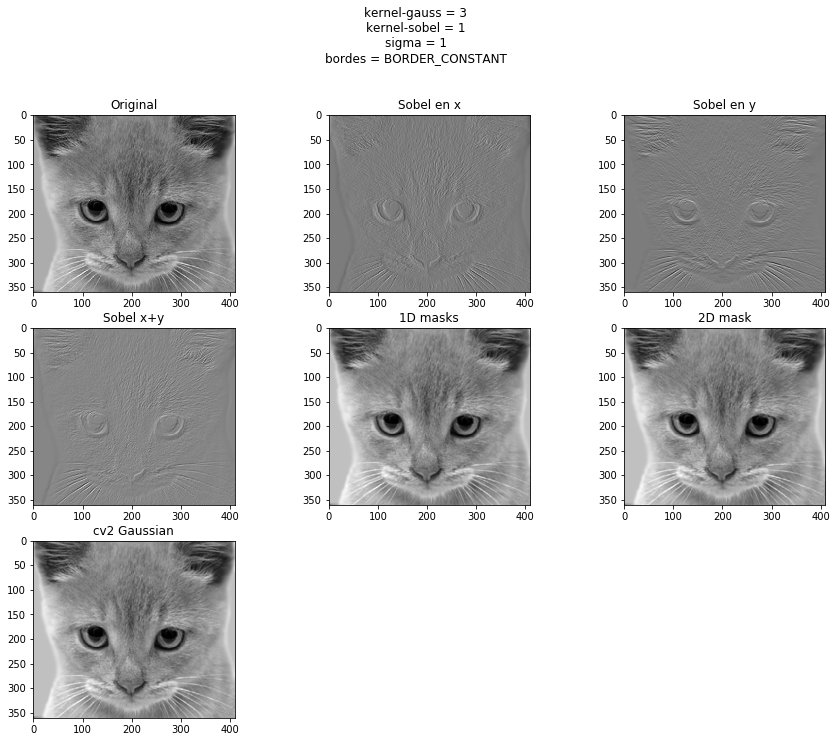

In [ ]:
main()